<h3>Predictors of Non-Voters in the United States</h3>

To-do:
* get accuracy rate for each method
* use toy data (iris) to prove our method works
* write up paper

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from numpy import linalg as la
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('no_voter_data.csv')

<h4>Data Cleaning and Manipulation

In [3]:
# create necessary columns for race 
df['white'] = np.where(df['race'] == 'White', 1, 0)
df['black'] = np.where(df['race'] == 'Black', 1, 0)
df['other/mixed'] = np.where(df['race'] == 'Other/Mixed', 1, 0)
df['hispanic'] = np.where(df['race'] == 'Hispanic', 1, 0)

In [4]:
# gender 
df['gender'] = np.where(df['gender'] == 'Female', 1, 0)

In [5]:
# income category
new_label = {"income_cat": {"Less than $40k":1, 
            "$40-75k":2, 
            "$75-125k":3,
            "$125k or more":4}}
df.replace(new_label, inplace = True)

In [6]:
# education category
new_label = {"educ": {"High school or less":1, 
            "Some college":2, 
            "College":3}}
df.replace(new_label, inplace = True)

In [7]:
# voter category data manipulations
new_label = {"voter_category": {"always":3, "sporadic":2, "rarely/never":1}}
df.replace(new_label, inplace = True)

In [8]:
# drop
df = df.drop(["race", "RespId", "weight"], axis=1)

# fill NA's 
df_2 = df.fillna(0)

In [9]:
y = df_2["voter_category"]
X = df_2.drop("voter_category", axis=1)

In [17]:
y.value_counts()

2    2574
3    1811
1    1451
Name: voter_category, dtype: int64

<h4>Create train and test data & create function to calculate accuracy

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# calculate accuracy all methods
def accuracy(y_hat, y_test):
    return np.mean(y_hat==y_test)

<h4> Method 1: Truncated SVD

In [11]:
# Truncated SVD
# use different # of cols and find which # minimizes error
def truncated_svd(X, y):
    svd_errors = []
    w_hats_svd = []
    _, p = X.shape
    u, s, vt = la.svd(X)
    sigma = np.zeros(X.shape)
    sigma1 = sigma.copy()

    for i in range(p):
        s1 = s[:i+1]
        np.fill_diagonal(sigma, np.append(s1, np.zeros(p - i + 1)))
        sigma_inv = la.pinv(sigma)
        w_hat_svd = vt.T@sigma_inv@u.T@y
        w_hats_svd.append(w_hat_svd)
        y_hat_svd = X@w_hat_svd
        svd_errors.append(np.mean(y - y_hat_svd)**2)

    best_param_svd = svd_errors.index(min(svd_errors))
    return best_param_svd, w_hats_svd[best_param_svd]

In [12]:
svd_best_num_col, svd_whats = truncated_svd(X_train, y_train)

In [23]:
y_hat_svd = np.rint(X_test @ svd_whats)

In [24]:
accuracy(y_hat_svd, y_test)

0.5847602739726028

In [77]:
svd_best_num_col

117

<h4> Method 2: Ridge Regression

In [23]:
# Ridge Regression
def rls(X, y, lambda_vals):
    
    #### RLS ####
    w_hat_lst = []
    errors_lst = []
    u, s, vt = la.svd(X)
    sigma = np.zeros(X.shape) # n x p
    sigma1 = sigma.copy() #creating copy 
    np.fill_diagonal(sigma1, s)
            
    for l, val in enumerate(lambda_vals):
        w_hat = la.inv(vt.T@sigma1.T@sigma1@vt + val)@vt.T@sigma1.T@u.T@y
        w_hat_lst.append(w_hat)

        y_tilde = X@w_hat
        error = np.mean((y_tilde - y)**2)
        errors_lst.append(error)

    best_param_index = errors_lst.index(min(errors_lst))
    best_w = w_hat_lst[best_param_index]
    best_lambda = lambda_vals[best_param_index]
    return best_lambda, best_w 


In [44]:
lambda_vals = np.array([0, 0.001, 0.01, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 64])

rls_best_lambda, rls_whats = rls(X, y, lambda_vals)

In [46]:
rls_whats_abs = abs(rls_whats)
ind = np.argpartition(rls_whats_abs, -10)[-10:]
ind

array([ 83,  58,  60,  82,  39, 116, 115, 118, 117,   0])

In [47]:
#df.iloc[:, 83]
df_new = X.iloc[:,ind]
df_new.columns

Index(['Q27_1', 'Q18_3', 'Q18_5', 'Q26', 'Q10_1', 'black', 'white', 'hispanic',
       'other/mixed', 'Q1'],
      dtype='object')

In [48]:
rls_whats[ind]

array([-0.07999981,  0.09917155, -0.10710976, -0.22806724,  0.10853891,
       -0.54468174, -0.56438447, -0.57507917, -0.65946731,  2.12527411])

In [29]:
y_hat_rls = np.rint(X_test @ rls_whats)
print(accuracy(y_hat_rls, y_test))
print(rls_best_lambda)

0.5976027397260274
0.001


<h4> Method 3: Principal Component Analysis

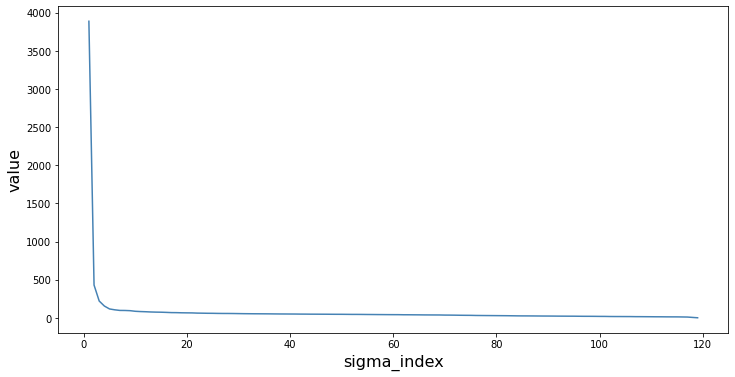

In [50]:
# PCA
u,s,vh = np.linalg.svd(X_train ,full_matrices=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,s.shape[0]+1), s, color="steelblue", label='sigmas')
ax.set_xlabel("sigma_index", fontsize=16)
ax.set_ylabel("value", fontsize=16)
plt.show()
fig.savefig("pca_sigmas.png")

# first 3 sigmas seem to be the most important; we will solve for 4 principle components! 

In [51]:
# calculate principal components
train_acc_lst = []
test_acc_lst = []
for i in range(1, s.shape[0]+1):
    pc = X_train@vh[:i,:].T
    z3 = pc

    # use 3 PC to compute least sqaures 
    w = np.linalg.inv(z3.T@z3)@z3.T@y_train
    y_pred = np.rint(z3@w)
    acc_train = accuracy(y_pred, y_train)
    train_acc_lst.append(acc_train)

    # test data
    z_test = vh[:i, :] @ X_test.T
    y_pred_test = np.rint(z_test.T@w)
    acc_test = accuracy(y_pred_test, y_test)
    test_acc_lst.append(acc_test)

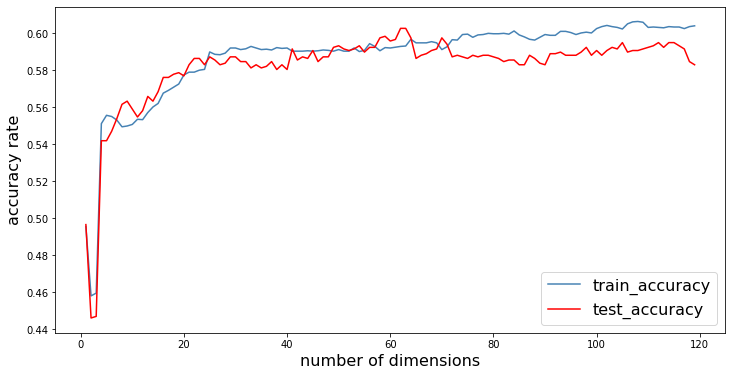

In [52]:
fig2, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,s.shape[0]+1), train_acc_lst, color="steelblue", label='train_accuracy')
ax.plot(range(1,s.shape[0]+1), test_acc_lst, color="red", label='test_accuracy')
ax.set_xlabel("number of dimensions", fontsize=16)
ax.set_ylabel("accuracy rate", fontsize=16)
ax.legend(loc="lower right", fontsize=16)
plt.show()
fig2.savefig("pca_train_test_acc.png")

In [75]:
test_acc_lst

[0.4965753424657534,
 0.4460616438356164,
 0.4469178082191781,
 0.5419520547945206,
 0.5419520547945206,
 0.5470890410958904,
 0.5539383561643836,
 0.5616438356164384,
 0.5633561643835616,
 0.5590753424657534,
 0.5547945205479452,
 0.5582191780821918,
 0.5659246575342466,
 0.5633561643835616,
 0.5684931506849316,
 0.5761986301369864,
 0.5761986301369864,
 0.5779109589041096,
 0.5787671232876712,
 0.577054794520548,
 0.5830479452054794,
 0.586472602739726,
 0.586472602739726,
 0.5830479452054794,
 0.5873287671232876,
 0.5856164383561644,
 0.5830479452054794,
 0.583904109589041,
 0.5873287671232876,
 0.5873287671232876,
 0.5847602739726028,
 0.5847602739726028,
 0.5813356164383562,
 0.5830479452054794,
 0.5813356164383562,
 0.5821917808219178,
 0.5847602739726028,
 0.5804794520547946,
 0.5830479452054794,
 0.5804794520547946,
 0.5916095890410958,
 0.5856164383561644,
 0.5873287671232876,
 0.586472602739726,
 0.5907534246575342,
 0.5847602739726028,
 0.5873287671232876,
 0.587328767123287

<h4> Method 4: Kernal Ridge

In [85]:
# Kernal Ridge
def kernel_ridge(X, y, X_test, y_test, sigma_sq_lst, lam):
    n, p = X.shape
    ntest, ptest = X_test.shape
    norms2 = (np.array(la.norm(X, axis =1)).T)**2 # squared norm of each training sample
    innerProds = X@X.T

    train_acc_lst_kr = []
    test_acc_lst_kr = []
    for sigma in sigma_sq_lst:
        # squared distances between each pair of training samples
        dist2 = np.matrix(norms2).T@np.ones([1, n]) + np.ones([n, 1])@np.matrix(norms2) - 2*innerProds 
        K = np.exp(-dist2/(2*sigma))
        alpha = (la.inv(K + lam*np.identity(n))@y)
        yhat_train = np.rint(K@alpha.T)
        train_acc_lst_kr.append(accuracy(yhat_train, y))
        
        norms2_test = (np.array(la.norm(X_test, axis =1)).T ) **2
        innerProds_test = X_test@X_train.T
        dist2_test = np.matrix(norms2_test).T@np.ones([1 , n]) + np.ones ([ntest ,1])@np.matrix(norms2) -2* innerProds_test
        k_test = np.exp(-dist2_test/(2*sigma))
        y_hat_test = np.rint(k_test@alpha.T)
        accuracy(y_hat_test, y_test)
        test_acc_lst_kr.append(accuracy(y_hat_test, y_test))

    best_param_i = train_acc_lst_kr.index(max(train_acc_lst_kr))
    print(best_param_i)
    print(len(train_acc_lst_kr))
    best_sigma_sq = sigma_sq_lst[best_param_i]
        
    return max(test_acc_lst_kr), best_sigma_sq

In [86]:
# initial sigma/lam
sigma_sq_lst = [.0001, .001, .01, .1, 0.5, 1, 5, 10, 25, 50, 100]
#sigma_sq_lst = [.0001, .001]
#sigma = 50
lam = 1
acc_kr, best_sigma_sq = kernel_ridge(X_train, y_train, X_test, y_test, sigma_sq_lst, lam)

8
11


In [87]:
print(best_sigma_sq)
acc_kr

25


0.5813356164383562

<h4> Method 5 (beyond class): Logistic Regression

In [51]:
# Logistic Regression
def one_hot(y, c):
    
    # y--> label/ground truth.
    # c--> Number of classes.
    
    # A zero matrix of size (m, c)
    y_hot = np.zeros((len(y), c))
    
    # Putting 1 for column where the label is,
    # Using multidimensional indexing.
    y_hot[np.arange(len(y)), y-1] = 1
    
    return y_hot

def softmax(z):
    
    # z--> linear part.
    
    # subtracting the max of z for numerical stability.
    exp = np.exp(z - np.max(z))
    
    # Calculating softmax for all examples.
    for i in range(len(z)):
        exp[i] /= np.sum(exp[i])
        
    return exp

def fit(X, y, lr, c, epochs):
    
    # X --> Input.
    # y --> true/target value.
    # lr --> Learning rate.
    # c --> Number of classes.
    # epochs --> Number of iterations.
    
        
    # m-> number of training examples
    # n-> number of features 
    m, n = X.shape
    
    # Initializing weights and bias randomly.
    w = np.random.random((n, c))
    b = np.random.random(c)
    # Empty list to store losses.
    losses = []
    
    # Training loop.
    for epoch in range(epochs):
        
        # Calculating hypothesis/prediction.
        z = X@w + b
        y_hat = softmax(z)
        
        # One-hot encoding y.
        y_hot = one_hot(y, c)
        
        # Calculating the gradient of loss w.r.t w and b.
        w_grad = (1/m)*np.dot(X.T, (y_hat - y_hot)) 
        b_grad = (1/m)*np.sum(y_hat - y_hot)
        
        # Updating the parameters.
        w = w - lr*w_grad
        b = b - lr*b_grad
        
        # Calculating loss and appending it in the list.
        loss = -np.mean(np.log(y_hat[np.arange(len(y)), y-1]))
        losses.append(loss)
        # # Printing out the loss at every 100th iteration.
        # if epoch%100==0:
        #     print('Epoch {epoch}==> Loss = {loss}'
        #           .format(epoch=epoch, loss=loss))
    return w, b, losses

def predict(X, w, b):
    
    # X --> Input.
    # w --> weights.
    # b --> bias.
    
    # Predicting
    z = X@w + b
    y_hat = softmax(z)
    
    # Returning the class with highest probability.
    preds = np.argmax(y_hat, axis=1)
    preds += 1
    return preds

In [52]:
# turn data into np arrays
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()
X_train_np.shape

(4668, 119)

In [53]:
# train and test on toy data (iris) logistic
from sklearn.datasets import load_iris

iris = load_iris()

X = iris['data']
y = iris['target']
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X, y, test_size=0.2, random_state=42)

# make labels 1, 2, 3 from 0, 1, 2

lrs = [.000001, .00001, .0001, .005, .01, .1, .2, .3, .5, 1]
logit_acc_iris = []
ws_iris = []
bs_iris = []
for l in lrs:
    w, b, l = fit(X_train_iris, y_train_iris, lr=l, c=3, epochs=1000)
    ws_iris.append(w)
    bs_iris.append(b)
    train_preds = predict(X_train_iris, w, b)
    logit_acc_iris.append(accuracy(y_train_iris, train_preds))

# get lr w/ min train err
best_param_lr_i = logit_acc_iris.index(max(logit_acc_iris))
best_lr_i = lrs[best_param_lr_i]
best_w_i = ws_iris[best_param_lr_i]
best_b_i = bs_iris[best_param_lr_i]

pred_class_i = predict(X_test_iris, best_w_i, best_b_i)
# get test accuracy
accuracy(y_test_iris, pred_class_i)

0.6333333333333333

In [54]:
# train and test
logit_acc = []
ws = []
bs = []
for l in lrs:
    w, b, l = fit(X_train_np, y_train_np, lr=l, c=3, epochs=1000)
    ws.append(w)
    bs.append(b)
    train_preds = predict(X_train_np, w, b)
    logit_acc.append(accuracy(y_train_np, train_preds))

# get lr w/ min train err
best_param_lr = logit_acc.index(max(logit_acc))
best_lr = lrs[best_param_lr]
best_w = ws[best_param_lr]
best_b = bs[best_param_lr]

pred_class = predict(X_test_np, best_w, best_b)

# get test accuracy
accuracy(y_test_np, pred_class)

/var/folders/8g/3jp0k1x54d1f91mld1sc5gq80000gn/T/ipykernel_18558/3314986497.py:67: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(np.log(y_hat[np.arange(len(y)), y-1]))
/var/folders/8g/3jp0k1x54d1f91mld1sc5gq80000gn/T/ipykernel_18558/3314986497.py:25: RuntimeWarning: invalid value encountered in true_divide
  exp[i] /= np.sum(exp[i])


0.5368150684931506

In [80]:
best_lr

0.1

<h4> Method 6 (beyond class): Random Forest

In [12]:
import numpy as np
from collections import Counter


class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [13]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.
        
        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.
        
        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))
    
    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

In [14]:
class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees=25, min_samples_split=2, max_depth=5):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        # Will store individually trained decision trees
        self.decision_trees = []
        
    @staticmethod
    def _sample(X, y):
        '''
        Helper function used for boostrap sampling.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: tuple (sample of features, sample of target)
        '''
        n_rows, n_cols = X.shape
        # Sample with replacement
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], y[samples]
        
    def fit(self, X, y):
        '''
        Trains a Random Forest classifier.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: None
        '''
        # Reset
        if len(self.decision_trees) > 0:
            self.decision_trees = []
            
        # Build each tree of the forest
        num_built = 0
        while num_built < self.num_trees:
            try:
                clf = DecisionTree(
                    min_samples_split=self.min_samples_split,
                    max_depth=self.max_depth
                )
                # Obtain data sample
                _X, _y = self._sample(X, y)
                # Train
                clf.fit(_X, _y)
                # Save the classifier
                self.decision_trees.append(clf)
                num_built += 1
            except Exception as e:
                continue
    
    def predict(self, X):
        '''
        Predicts class labels for new data instances.
        
        :param X: np.array, new instances to predict
        :return: 
        '''
        # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))
        
        # Reshape so we can find the most common value
        y = np.swapaxes(a=y, axis1=0, axis2=1)
        
        # Use majority voting for the final prediction
        predictions = []
        for preds in y:
            counter = Counter(preds)
            predictions.append(counter.most_common(1)[0][0])
        return predictions

In [60]:
# train and test on toy data (iris) random forest
model = RandomForest()
model.fit(X_train_iris, y_train_iris)
preds_iris = model.predict(X_test_iris)

accuracy(y_test_iris, preds_iris)

1.0

In [15]:
model = RandomForest()
model.fit(X_train.to_numpy(), y_train.to_numpy())
preds = np.rint(model.predict(X_test.to_numpy()))
accuracy(preds, y_test)

0.6429794520547946

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# Create confusion matrix
print(confusion_matrix(y_test, preds))

# Display accuracy score
print(accuracy_score(y_test, preds))

# Display F1 score
print(f1_score(y_test,preds, average='weighted'))

[[179  62  45]
 [ 29 318 152]
 [ 11 118 254]]
0.6429794520547946
0.6458541434827093


In [ ]:
# choose columns we find important and see if that affects accuracy at all????  

In [ ]:
# bootstrapping
# aggregation (bagging)
# trees will give 
# how many features to consider? sq root of total # of features; 119**(1/2) = ~11